# Basis Pursuit

**Author: M. Ravasi, KAUST**

Welcome to the second exercise of the **An introduction to proximal solvers for engineers** course!

The aim of this tutorial is to:

- Learn how to solve a Basis Pursuit problem with PyProximal;
- Compare the performance of different proximal solvers when applied to the same objective function.

Let's first import the libraries we need in this tutorial

In [1]:
# Run this when using Colab (will install the missing libraries)
# !pip install pylops pyproximal

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pyproximal

from pylops import FirstDerivative, MatrixMult, Restriction, SecondDerivative
from pylops.signalprocessing import FFT

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
def callback(x, xtrue, xerr):
    xerr.append(np.linalg.norm(x-xtrue))

## Problem statement

From a mathematical point of view we seek the sparsest solution that satisfies a system of equations.

$$
argmin_\mathbf{x} \|\mathbf{x}\|_1 \; \text{s.t.} \; \mathbf{Gx} = \mathbf{d}
$$

where the operator $\mathbf{A}$ is of size $N \times M$, and generally $N<M$.

Note that this problem is similar to the more general $L_1$ regularized inversion; however, it presents a stricter condition on the data term which must be satisfied exactly. Similarly, we can also consider the Basis Pursuit Denoise problem

$$
argmin_\mathbf{x} \|\mathbf{x}\|_1 \; \text{s.t.} \;  \|\mathbf{Gx} - \mathbf{d}\|_2 < \epsilon
$$


Let’s start by creating the input vector $\mathbf{x}$, operator $\mathbf{A}$, and data $\mathbf{y}$

In [4]:
n, m = 40, 100
mava = 10

# model
x = np.zeros(m)
iava = np.random.permutation(np.arange(m))[:mava]
x[iava] = np.random.normal(0, 1, mava)

# operator
G = np.random.normal(0, 1, (n, m))
Gop = MatrixMult(G)

# data
d = Gop * x

We focus now on the Basis Pursuit case and use HQS first

HQS
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.AffineSet.AffineSet'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
tau = Variable	niter = 150

   Itn       x[0]          f           g       J = f + g
     1   7.08843e-02   0.000e+00   1.251e+01   1.251e+01
     2   7.08843e-02   0.000e+00   1.251e+01   1.251e+01
     3   7.08843e-02   0.000e+00   1.251e+01   1.251e+01
     4   7.08843e-02   0.000e+00   1.251e+01   1.251e+01
     5   7.08843e-02   0.000e+00   1.251e+01   1.251e+01
     6   7.08843e-02   0.000e+00   1.251e+01   1.251e+01
     7   7.04028e-02   0.000e+00   1.248e+01   1.248e+01
     8   6.84698e-02   0.000e+00   1.239e+01   1.239e+01
     9   6.57952e-02   0.000e+00   1.222e+01   1.222e+01
    10   6.32921e-02   0.000e+00   1.197e+01   1.197e+01
    16   3.74085e-02   0.000e+00   1.021e+01   1.021e+01
    31   2.27071e-03   0.000e+00   8.057e+00   8.057e+00
    46  -2.74725e-04   0.000e+00   7.

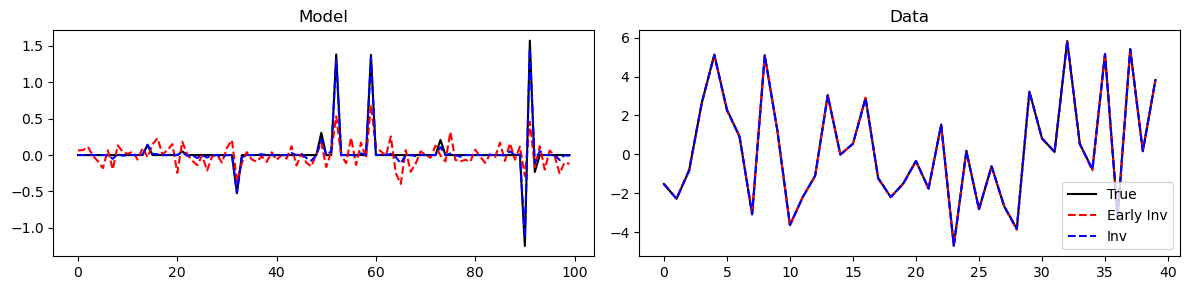

In [5]:
f = pyproximal.AffineSet(Gop, d, niter=20)
g = pyproximal.L1()

tau = 0.9 ** np.arange(150)
xhqs_early = pyproximal.optimization.primal.HQS(f, g, np.zeros_like(x),
                                                tau[:10], niter=10)[0]

xhqs_err = []
xhqs = pyproximal.optimization.primal.HQS(f, g, np.zeros_like(x),
                                          tau, niter=150, show=True,
                                          callback=lambda xest: callback(xest, x, xhqs_err))[0]

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].plot(x, 'k')
axs[0].plot(xhqs_early, '--r')
axs[0].plot(xhqs, '--b')
axs[0].set_title('Model')
axs[1].plot(d, 'k', label='True')
axs[1].plot(Gop * xhqs_early, '--r', label='Early Inv')
axs[1].plot(Gop * xhqs, '--b', label='Inv')
axs[1].set_title('Data')
axs[1].legend()
plt.tight_layout()

Let's use ADMM now instead

ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.AffineSet.AffineSet'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
tau = 1.000000e-01	niter = 150

   Itn       x[0]          f           g       J = f + g
     1   7.08843e-02   0.000e+00   1.251e+01   1.251e+01
     2  -4.27771e-02   0.000e+00   1.051e+01   1.051e+01
     3  -5.12519e-02   0.000e+00   1.050e+01   1.050e+01
     4  -2.52996e-02   0.000e+00   9.803e+00   9.803e+00
     5  -6.03514e-03   0.000e+00   9.496e+00   9.496e+00
     6  -3.26570e-03   0.000e+00   9.235e+00   9.235e+00
     7   1.72996e-03   0.000e+00   8.999e+00   8.999e+00
     8   4.28581e-03   0.000e+00   8.815e+00   8.815e+00
     9   6.38460e-03   0.000e+00   8.569e+00   8.569e+00
    10   6.11360e-03   0.000e+00   8.435e+00   8.435e+00
    16   1.49683e-03   0.000e+00   7.721e+00   7.721e+00
    31  -9.85401e-04   0.000e+00   7.132e+00   7.132e+00
    46  -3.03155e-04   0.000e+00

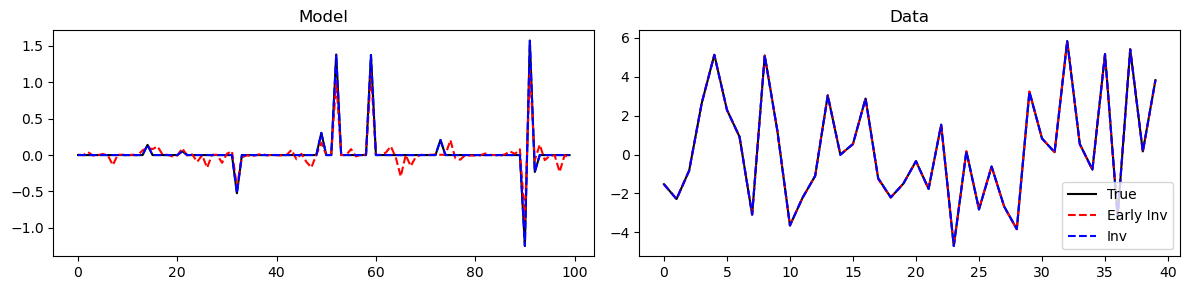

In [6]:
f = pyproximal.AffineSet(Gop, d, niter=20)
g = pyproximal.L1()

xadmm_early = pyproximal.optimization.primal.ADMM(f, g, np.zeros_like(x),
                                                  0.1, niter=10)[0]

xadmm_err = []
xadmm = pyproximal.optimization.primal.ADMM(f, g, np.zeros_like(x),
                                            0.1, niter=150, show=True,
                                            callback=lambda xest: callback(xest, x, xadmm_err))[0]

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].plot(x, 'k')
axs[0].plot(xadmm_early, '--r')
axs[0].plot(xadmm, '--b')
axs[0].set_title('Model')
axs[1].plot(d, 'k', label='True')
axs[1].plot(Gop * xadmm_early, '--r', label='Early Inv')
axs[1].plot(Gop * xadmm, '--b', label='Inv')
axs[1].set_title('Data')
axs[1].legend()
plt.tight_layout()

And finally we compare the converge behaviour of the two solvers

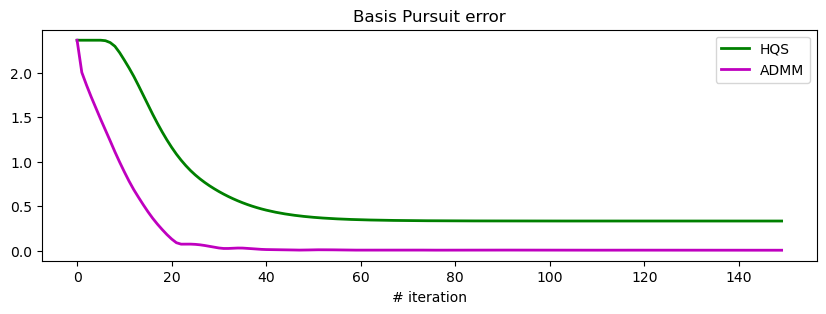

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(xhqs_err, "g", lw=2, label="HQS")
ax.plot(xadmm_err, "m", lw=2, label="ADMM")
ax.set_title("Basis Pursuit error")
ax.set_xlabel('# iteration')
ax.legend();

Finally, let's see how we can easily switch to the Basis Pursuit Denoise problem

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L1.L1'>
Proximal operator (g): <class 'pyproximal.proximal.Euclidean.EuclideanBall'>
Linear operator (A): <class 'pylops.basicoperators.matrixmult.MatrixMult'>
Additional vector (z): None
tau = 0.99		mu = 0.003966546053158802
theta = 1.00		niter = 150

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   0.00000e+00   0.000e+00   0.000e+00   0.000e+00       0.000e+00
     2   0.00000e+00   0.000e+00   0.000e+00   0.000e+00       0.000e+00
     3   0.00000e+00   0.000e+00   0.000e+00   0.000e+00       0.000e+00
     4   0.00000e+00   1.431e-01   0.000e+00   0.000e+00       1.431e-01
     5   0.00000e+00   8.452e-01   0.000e+00   0.000e+00       8.452e-01
     6   0.00000e+00   2.129e+00   0.000e+00   0.000e+00       2.129e+00
     7   0.00000e+00   3.613e+00   0.000e+00   0.000e+00       3.613e+00
     8   0.

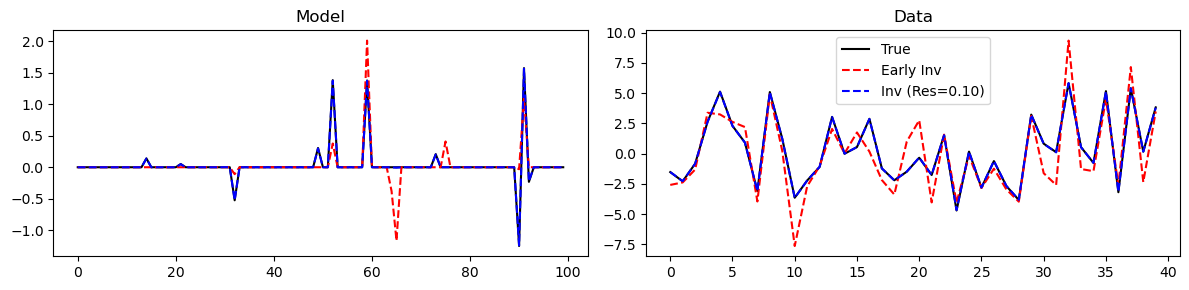

In [8]:
f = pyproximal.L1()
g = pyproximal.proximal.EuclideanBall(d, .1)

L = np.real((Gop.H @ Gop).eigs(1))[0]
tau = .99
mu = tau / L

xpd_early = pyproximal.optimization.primaldual.PrimalDual(f, g, Gop, np.zeros_like(x),
                                                           tau, mu, niter=10)

xpd_err = []
xpd = pyproximal.optimization.primaldual.PrimalDual(f, g, Gop, np.zeros_like(x),
                                                    tau, mu, niter=150, show=True,
                                                    callback=lambda xest: callback(xest, x, xpd_err))

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].plot(x, 'k')
axs[0].plot(xpd_early, '--r')
axs[0].plot(xpd, '--b')
axs[0].set_title('Model')
axs[1].plot(d, 'k', label='True')
axs[1].plot(Gop * xpd_early, '--r', label='Early Inv')
axs[1].plot(Gop * xpd, '--b', label='Inv (Res=%.2f)' % np.linalg.norm(d - Gop @ xpd))
axs[1].set_title('Data')
axs[1].legend()
plt.tight_layout()

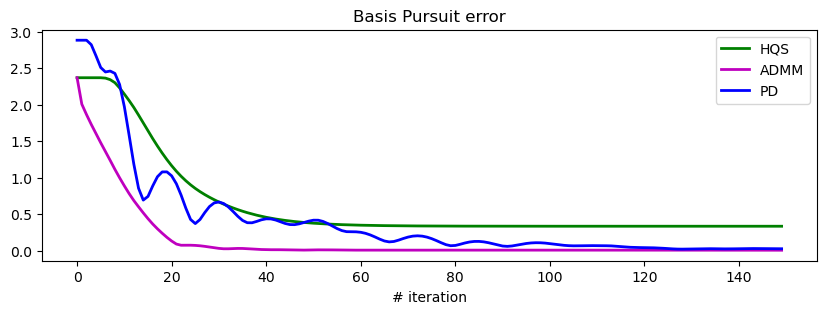

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(xhqs_err, "g", lw=2, label="HQS")
ax.plot(xadmm_err, "m", lw=2, label="ADMM")
ax.plot(xpd_err, "b", lw=2, label="PD")
ax.set_title("Basis Pursuit error")
ax.set_xlabel('# iteration')
ax.legend();

## Recap

In this first tutorial we have learned to:

- How to set up the Basis Pursuit and Basis Pursuit Denoise problems in PyProximal;
- How to compare different optimizers (and use callbacks to track the converge behaviour of different solutions).